In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline  

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from func2graph.data import data_simulator, generate_simulation_data
from func2graph import models, tools

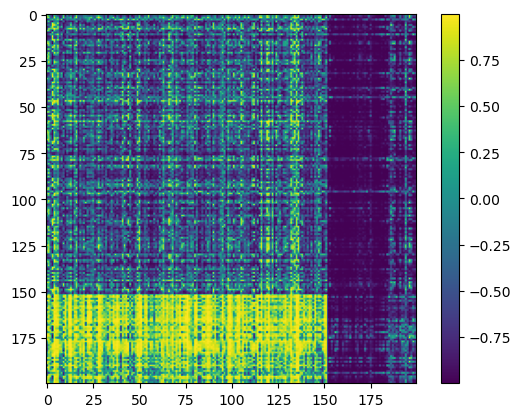

In [4]:
estimated = np.load('../../output/11_7_corrected_data/Attention_Autoencoder_wuwei_200_0.001_0.3_2_5_1.0_1.0_30000_42_cell_type_200_prediction_1_42_32_128_128_0_1_1_200_64_0_5e-05_lookup_table_spatial_temporal_1_tanh_plateau/Estimated_W_42.npy')

plt.imshow(-1*estimated)
plt.colorbar()
plt.show()

### Construct Data

In [3]:
neuron_num = 200   #####################
dt = 0.05
tau = 10

spike_neuron_num=2
spike_input=5

weight_scale = 1
init_scale = 1

total_time = 30000

data_random_seed=42 ######################

weight_type="random"

simulator = data_simulator(
    neuron_num=neuron_num, 
    dt=dt, 
    tau=tau, 
    spike_neuron_num=spike_neuron_num, 
    spike_input=spike_input,
    weight_scale= weight_scale,
    init_scale=init_scale,
    total_time=total_time,
    data_random_seed=data_random_seed,
    weight_type=weight_type,
)

result = []

for t in range(total_time):
    x_t = simulator.forward(t)
    x_t = x_t.view(-1, 1)
    result.append(x_t)

result = np.concatenate(result, axis=1)

print(result.shape)

(200, 30000)


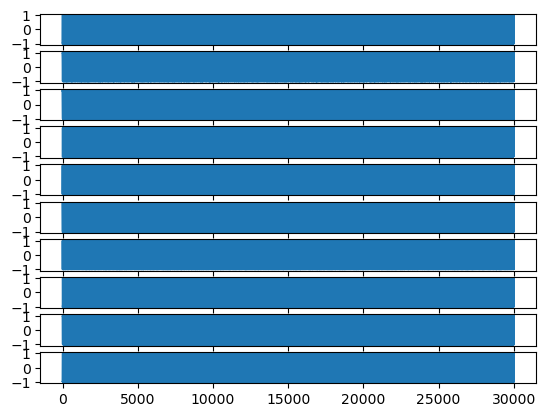

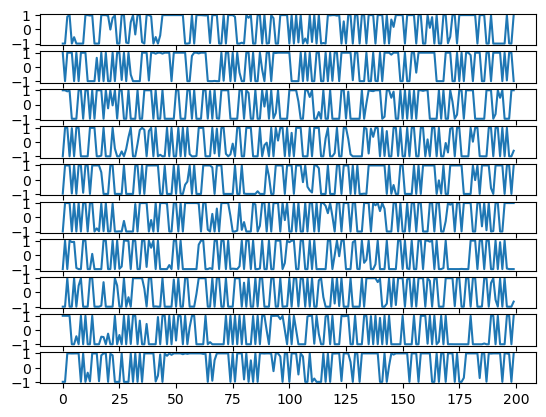

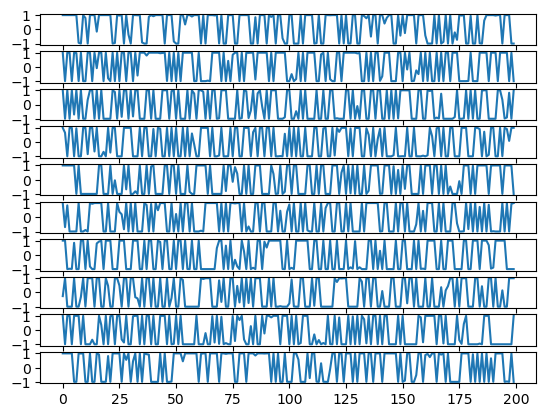

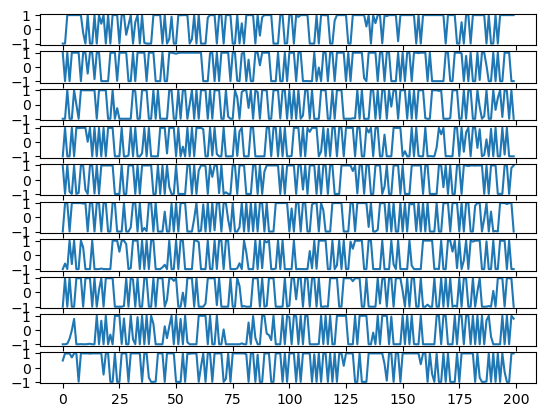

In [4]:
neuron_num = 10
for i in range(neuron_num):
    plt.subplot(10, 1, i+1)
    plt.plot(result[i])
plt.show()

for i in range(neuron_num):
    plt.subplot(10, 1, i+1)
    plt.plot(result[i][:200])
plt.show()

for i in range(neuron_num):
    plt.subplot(10, 1, i+1)
    plt.plot(result[i][400:600])
plt.show()

for i in range(neuron_num):
    plt.subplot(10, 1, i+1)
    plt.plot(result[i][5000:5200])


rank of the weight matrix:  200


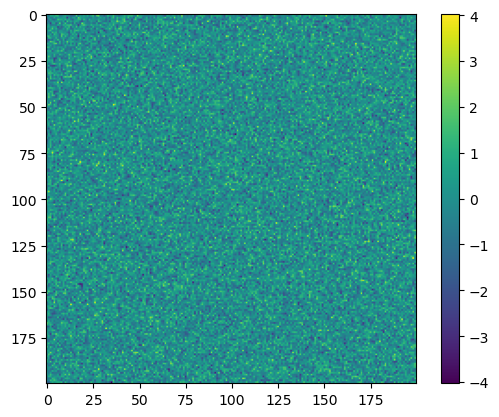

In [5]:
weight_matrix = simulator.W_ij

# compute the rank of the weight matrix
rank = np.linalg.matrix_rank(weight_matrix.detach().numpy())
print("rank of the weight matrix: ", rank)

plt.imshow(weight_matrix.detach().numpy())
plt.colorbar()
plt.show()

### Compare estimated W with ground truth

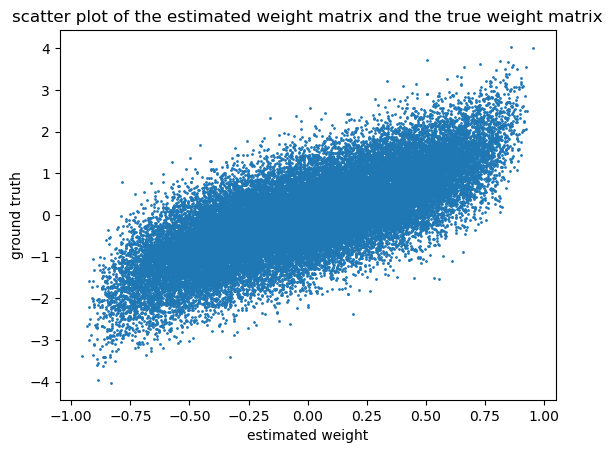

In [9]:
estimated_W = np.load("../../output/9_24_new_data_b/Attention_Autoencoder_wuwei_200_0.001_0.3_2_5_1.0_1.0_30000_42_random_20000_200_prediction_1_42_32_128_128_0_1_1_200_16_0_5e-05_lookup_table_spatial_temporal_1/Estimated_W_42.npy")

# plot scatter plot of the estimated weight matrix and the true weight matrix
plt.scatter(estimated_W.flatten(), weight_matrix.detach().numpy().flatten(), s=1)
plt.xlabel("estimated weight")
plt.ylabel("ground truth")
plt.title("scatter plot of the estimated weight matrix and the true weight matrix")
plt.show()

torch.Size([10, 30000])
val_data.shape:  torch.Size([5801, 10, 200])
tensor([[-0.5316, -0.9993,  0.8674,  ...,  0.9965,  0.7049, -0.9893],
        [-0.9291, -0.9986,  0.9799,  ...,  0.9962, -0.8513, -0.9822],
        [-0.9243,  0.9410,  0.9721,  ..., -1.0000, -0.9987, -0.4632],
        ...,
        [ 0.8905,  0.8456, -0.9036,  ...,  0.9868,  0.8381,  0.9671],
        [ 0.9965, -0.6076, -0.3854,  ...,  1.0000,  1.0000,  0.9849],
        [ 1.0000,  0.5903, -0.9324,  ...,  0.9986,  1.0000,  1.0000]])


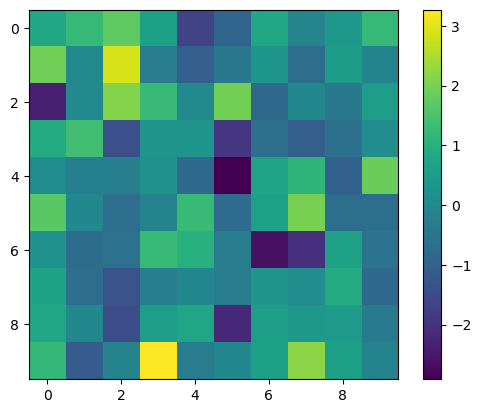

In [11]:
neuron_num = 10
dt = 0.001
tau = 0.3

spike_neuron_num=2
spike_input=20

random_seed=16
total_time = 30000

weight_type = "random"

train_dataloader, val_dataloader, weight_matrix = generate_simulation_data(neuron_num=neuron_num, 
                                                    dt=dt, 
                                                    tau=tau, 
                                                    spike_neuron_num=spike_neuron_num, 
                                                    spike_input=spike_input,
                                                    data_random_seed=random_seed,
                                                    total_time=total_time,
                                                    weight_type=weight_type,)

plt.imshow(weight_matrix.detach().numpy())
plt.colorbar()
plt.show()

torch.Size([32, 10, 200])


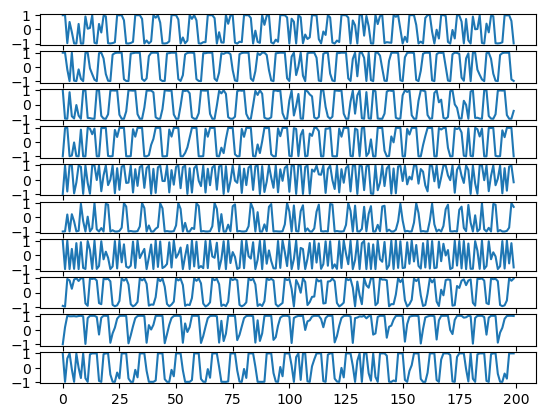

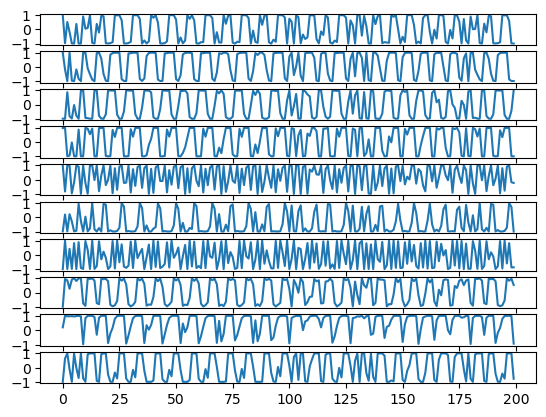

In [12]:
for i_batch, sample_batched in enumerate(train_dataloader):
    print(sample_batched[0].shape)
    samples = sample_batched[0][0:2]
    for i in range(neuron_num):
        plt.subplot(10, 1, i+1)
        plt.plot(samples[0][i])
    plt.show()
    for i in range(neuron_num):
        plt.subplot(10, 1, i+1)
        plt.plot(samples[1][i])
    plt.show()
    break